In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

In [2]:
### pre-processing steps
def one_hot(a):
    a = a.astype(int)
    m, n = a.size,a.max()
    b = np.zeros((m , n))
    b[np.arange(m), a-1] = 1
    return b

def normalise(X):
    X = (X-np.min(X, axis = 0, keepdims=True))/(np.max(X, axis = 0)-np.min(X, axis = 0))
    return X

def train_test_split(data, train_split = 0.7, test_split = 0.3):
    np.random.shuffle(data)
    x1 = int(0.7*data.shape[0])
    train_data = data[:x1, :]
    test_data = data[x1:, :]
    return train_data[:,:-1], train_data[:, -1], test_data[:, :-1], test_data[:,-1].astype(int)

In [3]:
### activation, loss functions 
def sigmoid(x):
    return 1/(1+np.exp(-x))
def sigmoid_der(x):
    return x*(1-x)
def softmax(x):
    num = np.exp(x - np.max(x, axis = 1, keepdims=True))
    denom = np.sum(num, axis = 1, keepdims = True)
    return num/denom
def cross_entropy(Ytrue, Ypred):
    n = Ytrue.shape[0]
    return (Ypred- Ytrue)/n
def cost(Ytrue, Ypred):
    n = Ytrue.shape[0]
    logterm = -np.log(Ypred[np.arange(n), Ytrue.argmax(axis = 1)])
    return np.sum(logterm)/n
def test_cost(Ytrue, Ypred):
    n = Ytrue.shape[0]
    logterm = -np.log(Ypred[np.arange(n), Ytrue])
    return np.sum(logterm)/n
def accuracy(Ytrue, Ypred):
    n = Ytrue.size
    correct = np.sum(Ytrue == Ypred)
    return (correct/n)*100

In [4]:
def loss_plot(loss, lr):
    fig = plt.figure()
    X = np.array(list(range(0,len(loss))))
    Y = np.transpose(np.array(loss))
    plt.plot(X,Y,"red")
    plt.title("Loss vs Iteration")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.figtext(.6, .3, f"Learning rate = {lr}")
    plt.show()
def accuracy_plot(acc, lr):
    fig = plt.figure()
    X = np.array(list(range(0,len(acc))))
    Y = np.transpose(np.array(acc))
    plt.plot(X,Y,"red")
    plt.title("Accuracy vs Iteration")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.figtext(.6, .3, f"Learning rate = {lr}")
    plt.show()

In [5]:
class ANN1:
    def __init__(self, X, Y, O, lr = 0.1):
        self.x = X
        self.y = Y
        self.o = O

        self.inpdim = X.shape[1]
        self.outdim = Y.shape[1]
        self.lr = lr
        self.hid_n1 = 256

        self.W1 = np.random.randn(self.inpdim, self.hid_n1)
        self.W2 = np.random.randn(self.hid_n1, self.outdim)
        self.b1 = np.zeros((1, self.hid_n1))
        self.b2 = np.zeros((1, self.outdim))

        self.loss = []
        self.accuracy = []

    def forward_prop(self):
        self.a1 = sigmoid(np.dot(self.x, self.W1) + self.b1)
        self.a2 = softmax(np.dot(self.a1, self.W2) + self.b2)

    def back_prop(self):
        a2_der = cross_entropy(self.y, self.a2)
        w1_der = np.dot(a2_der, self.W2.T)
        a1_der = w1_der * sigmoid_der(self.a1)

        self.W2 = self.W2 - self.lr * np.dot(self.a1.T, a2_der)
        self.W1 = self.W1 - self.lr * np.dot(self.x.T, a1_der)
        self.b2 = self.b2 - self.lr * np.sum(a2_der, axis = 0, keepdims=True)
        self.b1 = self.b1 - self.lr * np.sum(a1_der, axis = 0)

    def train(self, iter = 1000, show = 100,makefile = True):
        start = time.time()
        for i in range(iter+1):
            self.forward_prop()
            self.t = np.array(self.a2.argmax(axis = 1)+1)
            self.back_prop()
            self.accuracy.append(accuracy(self.o, self.t))
            self.loss.append(cost(self.y, self.a2))
            if makefile:
                if max(self.accuracy) == self.accuracy[i]:
                    f = open("best_weights1.hd5", "w")
                    f.write(f"Accuracy : {round(self.accuracy[i],2)}  Loss : {round(self.loss[i],2)}")
                    f.write(f"W1 : {self.W1}")
                    f.write(f"W2 : {self.W2}")
                    f.write(f"b1 : {self.b1}")
                    f.write(f"b2 : {self.b2}")
                    f.close()
            if i%show == 0:
                print(f"Iteration {i} ============ Accuracy : {round(self.accuracy[i],2)}  Loss : {round(self.loss[i],2)} Time taken : {round(time.time() - start, 2)} s")
                start = time.time()
                print()
    
    def test(self, x, y):
        self.x = x
        self.o = y.reshape(y.shape[0])
        self.forward_prop()
        self.t = np.array(self.a2.argmax(axis = 1)+1)
        print(f"TEST Accuracy {accuracy(self.o,self.t)} Loss {test_cost(self.o-1,self.a2)}") 

In [6]:
class ANN2:
    def __init__(self, X, Y, O ,lr = 0.1):
        self.x = X
        self.y = Y
        self.o = O

        self.inpdim = X.shape[1]
        self.outdim = Y.shape[1]
        self.lr = lr
        self.hid_n1 = 256
        self.hid_n2 = 128

        self.W1 = np.random.randn(self.inpdim, self.hid_n1)
        self.W2 = np.random.randn(self.hid_n1, self.hid_n2)
        self.W3 = np.random.randn(self.hid_n2, self.outdim)
        self.b1 = np.zeros((1, self.hid_n1))
        self.b2 = np.zeros((1, self.hid_n2))
        self.b3 = np.zeros((1, self.outdim))

        self.loss = []
        self.accuracy = []

    def forward_prop(self):
        self.a1 = sigmoid(np.dot(self.x, self.W1) + self.b1)
        self.a2 = sigmoid(np.dot(self.a1, self.W2) + self.b2)
        self.a3 = softmax(np.dot(self.a2, self.W3) + self.b3)

    def back_prop(self):
        a3_der = cross_entropy(self.y, self.a3)
        w2_der = np.dot(a3_der, self.W3.T)
        a2_der = w2_der * sigmoid_der(self.a2)
        w1_der = np.dot(a2_der, self.W2.T)
        a1_der = w1_der * sigmoid_der(self.a1)

        self.W3 = self.W3 - self.lr * np.dot(self.a2.T, a3_der)
        self.W2 = self.W2 - self.lr * np.dot(self.a1.T, a2_der)
        self.W1 = self.W1 - self.lr * np.dot(self.x.T, a1_der)
        self.b3 = self.b3 - self.lr * np.sum(a3_der, axis = 0, keepdims=True)
        self.b2 = self.b2 - self.lr * np.sum(a2_der, axis = 0)
        self.b1 = self.b1 - self.lr * np.sum(a1_der, axis = 0)

    def train(self, iter = 1000, show = 100, makefile = True):
        start = time.time()
        for i in range(iter+1):
            self.forward_prop()
            self.t = np.array(self.a3.argmax(axis = 1)+1)
            self.back_prop()
            self.accuracy.append(accuracy(self.o, self.t))
            self.loss.append(cost(self.y, self.a2))
            if makefile:
                if max(self.accuracy) == self.accuracy[i]:
                    f = open("best_weights2.hd5", "w")
                    f.write(f"Accuracy : {round(self.accuracy[i],2)}  Loss : {round(self.loss[i],2)}")
                    f.write(f"W1 : {self.W1}")
                    f.write(f"W2 : {self.W2}")
                    f.write(f"W3 : {self.W3}")
                    f.write(f"b1 : {self.b1}")
                    f.write(f"b2 : {self.b2}")
                    f.write(f"b3 : {self.b3}")
                    f.close()
            if i%show == 0:
                print(f"Iteration {i} ============ Accuracy : {round(self.accuracy[i],2)}  Loss : {round(self.loss[i],2)} Time taken : {round(time.time() - start, 2)} s")
                start = time.time()
                print()
    
    def test(self, x, y):
        self.x = x
        self.o = y.reshape(y.shape[0])
        self.forward_prop()
        self.t = np.array(self.a3.argmax(axis = 1)+1)
        print(f"TEST Accuracy {accuracy(self.o,self.t)} Loss {test_cost(self.o-1,self.a3)}") 




In [7]:

cd "C:\Users\Mudit\OneDrive\Desktop\PROJECTS\ML\ML---BITS-F464\Assignment-2\ANN_final\Assignment-2 Final"

C:\Users\Mudit\OneDrive\Desktop\PROJECTS\ML\ML---BITS-F464\Assignment-2\ANN_final\Assignment-2 Final


In [8]:
path = os.path.join('dataset_NN.csv')
dataset = pd.read_csv(path)
dataset = dataset.to_numpy()
dataset[:,:-1] = normalise(dataset[:,:-1])
dataset[:,-1] = dataset[:,-1].astype(int)
trainX , trainY, testX, testY = train_test_split(dataset, 0.7, 0.3)

Iteration 0 ============ Accuracy : 10.21  Loss : 19.11 Time taken : 0.03 s

Iteration 100 ============ Accuracy : 57.93  Loss : 1.24 Time taken : 2.13 s

Iteration 200 ============ Accuracy : 68.86  Loss : 1.0 Time taken : 2.16 s

Iteration 300 ============ Accuracy : 70.43  Loss : 0.91 Time taken : 2.27 s

Iteration 400 ============ Accuracy : 71.21  Loss : 0.86 Time taken : 2.09 s

Iteration 500 ============ Accuracy : 70.86  Loss : 0.83 Time taken : 2.2 s

Iteration 600 ============ Accuracy : 70.93  Loss : 0.81 Time taken : 2.02 s

Iteration 700 ============ Accuracy : 70.86  Loss : 0.79 Time taken : 1.86 s

Iteration 800 ============ Accuracy : 70.71  Loss : 0.78 Time taken : 1.79 s

Iteration 900 ============ Accuracy : 71.36  Loss : 0.77 Time taken : 1.78 s

Iteration 1000 ============ Accuracy : 71.57  Loss : 0.76 Time taken : 1.81 s

Iteration 1100 ============ Accuracy : 71.86  Loss : 0.75 Time taken : 1.76 s

Iteration 1200 ============ Accuracy : 71.93  Loss : 0.75 Time ta

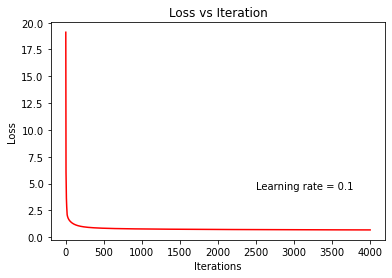

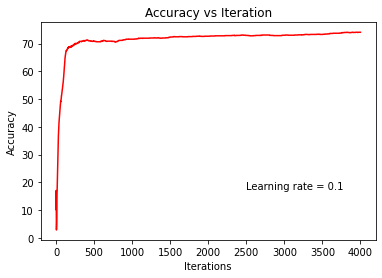

Iteration 0 ============ Accuracy : 13.43  Loss : 9.21 Time taken : 0.03 s

Iteration 100 ============ Accuracy : 44.71  Loss : 1.44 Time taken : 1.85 s

Iteration 200 ============ Accuracy : 61.29  Loss : 1.19 Time taken : 1.84 s

Iteration 300 ============ Accuracy : 66.5  Loss : 1.07 Time taken : 1.84 s

Iteration 400 ============ Accuracy : 68.07  Loss : 0.99 Time taken : 3.77 s

Iteration 500 ============ Accuracy : 69.14  Loss : 0.94 Time taken : 1.99 s

Iteration 600 ============ Accuracy : 69.57  Loss : 0.9 Time taken : 1.96 s

Iteration 700 ============ Accuracy : 69.86  Loss : 0.87 Time taken : 1.96 s

Iteration 800 ============ Accuracy : 70.14  Loss : 0.85 Time taken : 1.85 s

Iteration 900 ============ Accuracy : 70.43  Loss : 0.84 Time taken : 1.89 s

Iteration 1000 ============ Accuracy : 70.43  Loss : 0.82 Time taken : 1.94 s

Iteration 1100 ============ Accuracy : 70.71  Loss : 0.81 Time taken : 2.04 s

Iteration 1200 ============ Accuracy : 70.79  Loss : 0.8 Time take

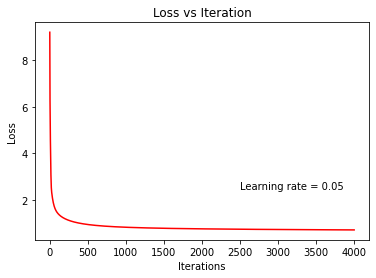

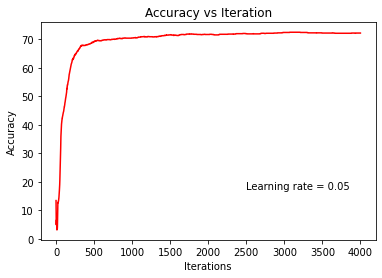

Iteration 0 ============ Accuracy : 18.64  Loss : 13.94 Time taken : 0.02 s

Iteration 100 ============ Accuracy : 29.43  Loss : 2.04 Time taken : 1.62 s

Iteration 200 ============ Accuracy : 42.79  Loss : 1.8 Time taken : 1.62 s

Iteration 300 ============ Accuracy : 44.21  Loss : 1.67 Time taken : 1.64 s

Iteration 400 ============ Accuracy : 45.93  Loss : 1.57 Time taken : 1.63 s

Iteration 500 ============ Accuracy : 47.86  Loss : 1.49 Time taken : 1.63 s

Iteration 600 ============ Accuracy : 48.14  Loss : 1.42 Time taken : 1.61 s

Iteration 700 ============ Accuracy : 49.0  Loss : 1.37 Time taken : 1.64 s

Iteration 800 ============ Accuracy : 51.21  Loss : 1.32 Time taken : 1.66 s

Iteration 900 ============ Accuracy : 53.29  Loss : 1.28 Time taken : 1.97 s

Iteration 1000 ============ Accuracy : 55.79  Loss : 1.24 Time taken : 1.86 s

Iteration 1100 ============ Accuracy : 58.79  Loss : 1.21 Time taken : 1.82 s

Iteration 1200 ============ Accuracy : 61.14  Loss : 1.18 Time ta

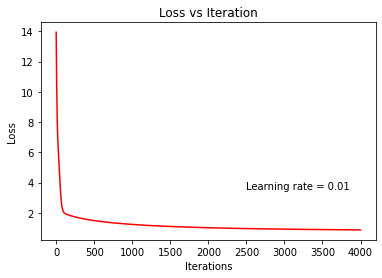

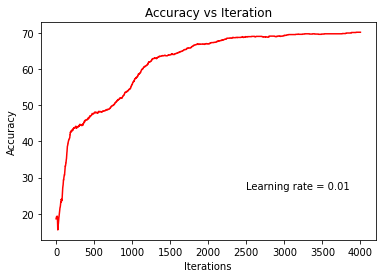

In [9]:
learning_rate = [0.1, 0.05, 0.01]

for i in range(3):
    myANN1 = ANN1(trainX,one_hot(trainY), trainY,lr=learning_rate[i])
    myANN1.train(4000, 100, makefile= False)
    myANN1.test(testX, testY)
    loss_plot(myANN1.loss,myANN1.lr)
    accuracy_plot(myANN1.accuracy, myANN1.lr)

Iteration 0 ============ Accuracy : 9.93  Loss : 2.44 Time taken : 0.08 s

Iteration 100 ============ Accuracy : 65.71  Loss : 2.43 Time taken : 4.05 s

Iteration 200 ============ Accuracy : 67.57  Loss : 2.45 Time taken : 3.82 s

Iteration 300 ============ Accuracy : 68.43  Loss : 2.47 Time taken : 3.73 s

Iteration 400 ============ Accuracy : 69.57  Loss : 2.51 Time taken : 3.57 s

Iteration 500 ============ Accuracy : 70.43  Loss : 2.55 Time taken : 3.6 s

Iteration 600 ============ Accuracy : 71.57  Loss : 2.59 Time taken : 3.57 s

Iteration 700 ============ Accuracy : 71.64  Loss : 2.64 Time taken : 3.54 s

Iteration 800 ============ Accuracy : 71.5  Loss : 2.67 Time taken : 3.55 s

Iteration 900 ============ Accuracy : 71.71  Loss : 2.71 Time taken : 3.6 s

Iteration 1000 ============ Accuracy : 71.93  Loss : 2.74 Time taken : 3.62 s

Iteration 1100 ============ Accuracy : 72.07  Loss : 2.76 Time taken : 3.58 s

Iteration 1200 ============ Accuracy : 72.43  Loss : 2.79 Time taken

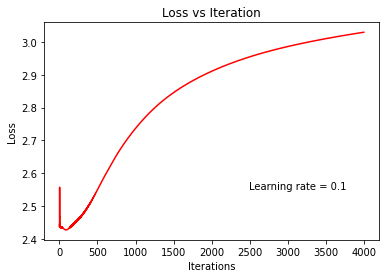

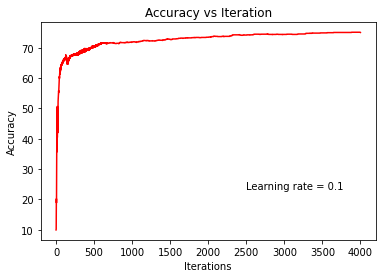

Iteration 0 ============ Accuracy : 7.5  Loss : 1.89 Time taken : 0.06 s

Iteration 100 ============ Accuracy : 66.36  Loss : 2.13 Time taken : 3.67 s

Iteration 200 ============ Accuracy : 68.64  Loss : 2.17 Time taken : 3.68 s

Iteration 300 ============ Accuracy : 69.71  Loss : 2.18 Time taken : 3.34 s

Iteration 400 ============ Accuracy : 70.0  Loss : 2.16 Time taken : 3.56 s

Iteration 500 ============ Accuracy : 70.36  Loss : 2.15 Time taken : 3.35 s

Iteration 600 ============ Accuracy : 70.86  Loss : 2.13 Time taken : 3.08 s

Iteration 700 ============ Accuracy : 71.07  Loss : 2.1 Time taken : 3.43 s

Iteration 800 ============ Accuracy : 71.0  Loss : 2.07 Time taken : 4.96 s

Iteration 900 ============ Accuracy : 71.36  Loss : 2.03 Time taken : 3.1 s

Iteration 1000 ============ Accuracy : 71.57  Loss : 2.01 Time taken : 3.06 s

Iteration 1100 ============ Accuracy : 71.71  Loss : 2.0 Time taken : 3.08 s

Iteration 1200 ============ Accuracy : 71.64  Loss : 1.99 Time taken : 

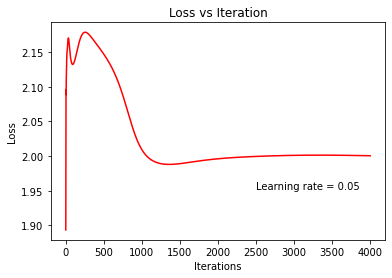

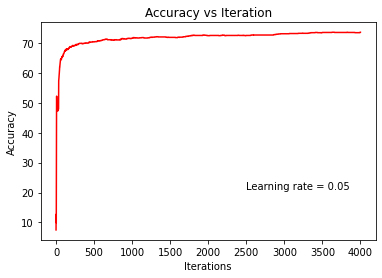

Iteration 0 ============ Accuracy : 10.21  Loss : 4.65 Time taken : 0.03 s

Iteration 100 ============ Accuracy : 52.93  Loss : 4.49 Time taken : 3.18 s

Iteration 200 ============ Accuracy : 57.57  Loss : 4.48 Time taken : 5.02 s

Iteration 300 ============ Accuracy : 61.43  Loss : 4.48 Time taken : 3.12 s

Iteration 400 ============ Accuracy : 64.29  Loss : 4.48 Time taken : 3.13 s

Iteration 500 ============ Accuracy : 65.86  Loss : 4.48 Time taken : 3.07 s

Iteration 600 ============ Accuracy : 67.71  Loss : 4.49 Time taken : 3.29 s

Iteration 700 ============ Accuracy : 68.21  Loss : 4.49 Time taken : 3.08 s

Iteration 800 ============ Accuracy : 68.71  Loss : 4.5 Time taken : 3.73 s

Iteration 900 ============ Accuracy : 69.43  Loss : 4.51 Time taken : 3.65 s

Iteration 1000 ============ Accuracy : 69.64  Loss : 4.51 Time taken : 3.69 s

Iteration 1100 ============ Accuracy : 70.07  Loss : 4.52 Time taken : 3.8 s

Iteration 1200 ============ Accuracy : 70.21  Loss : 4.52 Time tak

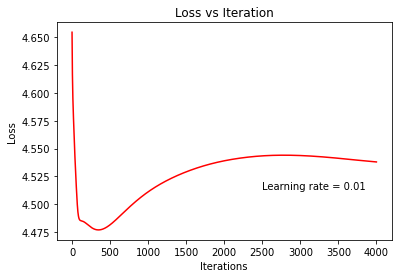

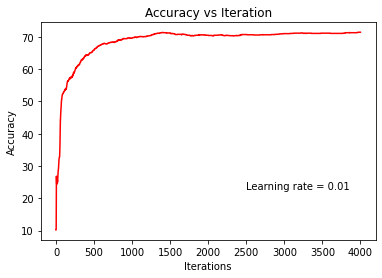

In [10]:
learning_rate = [0.1, 0.05, 0.01]

for i in range(3):
    myANN2 = ANN2(trainX,one_hot(trainY), trainY,lr=learning_rate[i])
    myANN2.train(4000, 100, makefile= False)
    myANN2.test(testX, testY)
    loss_plot(myANN2.loss,myANN2.lr)
    accuracy_plot(myANN2.accuracy, myANN2.lr)